# Introducción a estrategias de trading
## Construcción sencilla de señales de compra/venta

Viernes 31 de octubre de 2026

+ El trading automatizado/algorítmico consiste en construir un programa que pueda "analizar" datos del mercado y tomar decisiones de compra y venta.

+ La idea es utilizar precios históricos de acciones y algunas operaciones básicas para decidir cuándo comprar o vender.

+ Antes de considerarlo una estrategia de trading "real", se debe probar el sistema con datos históricos para evaluar qué tan bien funciona.

+ Esto ayudará a crear un sistema de trading simple e inteligente que funcione de manera relativamente automática.

+ Los indicadores (técnicos o de análisis técnico) ayudan a identificar tendencias y generar señales de trading.

+ Las medias móviles suavizan las series de datos de precios durante un número determinado de días, lo que facilita identificar tendencias y filtrar el ruido a corto plazo.

$$SMA_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}$$

* $SMA_t$: Promedio móvil simple al tiempo $t$
* $n$: Número de periodos
* $P_{t-i}$ : Precio de la acción al tiempo $t-i$

+ Simple Moving Averages (SMA):
  + SMA50 (tendencia a corto plazo / short-term trend)
  + SMA200 (tendencia a largo plazo / long-term trend)

Empecemos poco a poco....

Se debe definir señales de compra/venta ¿Porqué?

* Ayudan a tomar decisiones de trading basadas en tendencias históricas.

* En este caso específico serán una guía (visual) clara sobre cuándo entrar o salir del mercado según los cruces de medias.

Las señales de trading se crean a partir de los cruces entre las SMAs:

* **Señal de Compra (1)**: Si SMA50 > SMA200.
* **Señal de Venta (-1)**: Si SMA50 < SMA200.

In [1]:
import yfinance as yf  # Para descargar históricos de acciones de Yahoo Finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Definimos el ticker y las fechas que se quieren
ticker = "AAPL"  # Apple
fecha_inicio = "2018-01-01"
fecha_final = "2025-01-01"

# Se obtienen los datos históricos de Yahoo Finance
datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)

/tmp/ipython-input-3079217167.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
[*********************100%***********************]  1 of 1 completed


In [3]:
# Se calcular SMAs
short_window = 50
long_window = 200

datos['SMA_corto'] = datos['Close'].rolling(window = short_window).mean()
datos['SMA_largo'] = datos['Close'].rolling(window = long_window).mean()

# 1 : Señal de compra
# -1: Señal de venta
datos['signal'] = np.where(datos['SMA_corto'] > datos['SMA_largo'], 1, -1)

# Se eliminan los NAs
datos = datos.dropna()

In [4]:
datos.tail()

Price,Close,High,Low,Open,Volume,SMA_corto,SMA_largo,signal
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,234.988821,210.666910,1
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,235.495562,211.097454,1
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,235.975154,211.521334,1
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,236.379820,211.919041,1
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,236.692276,212.309766,1


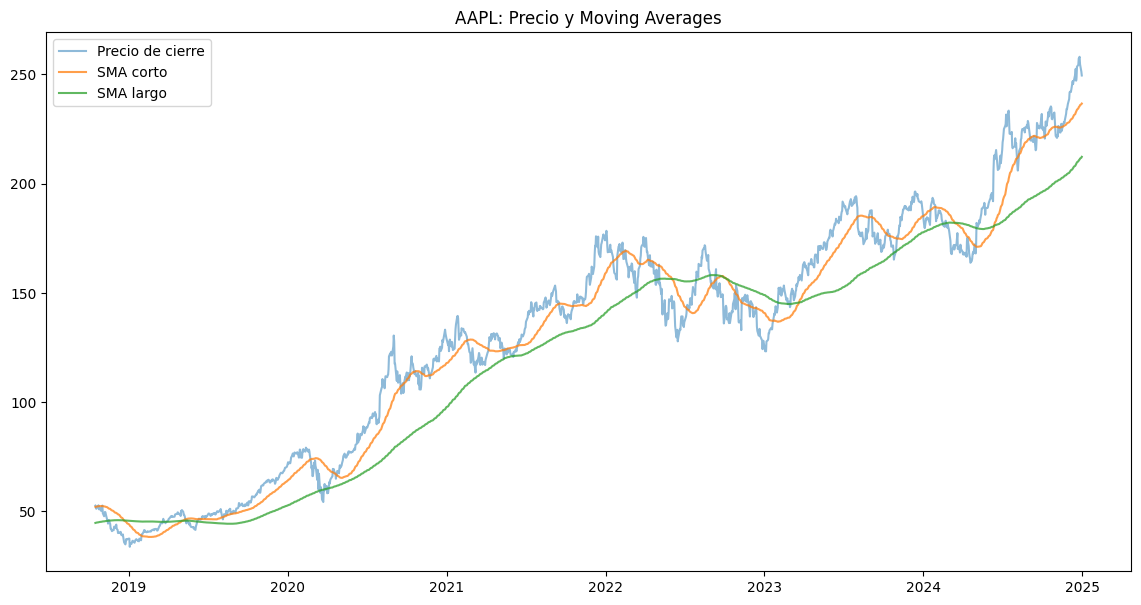

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(datos['Close'], label = 'Precio de cierre', alpha=0.5)
plt.plot(datos['SMA_corto'], label = 'SMA corto', alpha=0.75)
plt.plot(datos['SMA_largo'], label = 'SMA largo', alpha=0.75)
plt.title(f"{ticker}: Precio y Moving Averages")
plt.legend()
plt.show()

In [6]:
# Se genera una columna de posiciones, se recorren las señales para evitar
# El sesgo look-akead
# La posición refleja la señal del día anterior
datos['posicion'] = datos['signal'].shift(1)

# Se calcula el cambio porcentual diario del precio de la acción
datos['rendim_diario'] = datos['Close'].pct_change()

datos['rendim_estrategia'] = datos['posicion'] * datos['rendim_diario']

# Se obtienen los rendimientos acumulados
datos['rendim_acumulado_accion'] = (1 + datos['rendim_diario']).cumprod()
datos['rendim_acumlado_estrategia'] = (1 + datos['rendim_estrategia']).cumprod()

<Axes: >

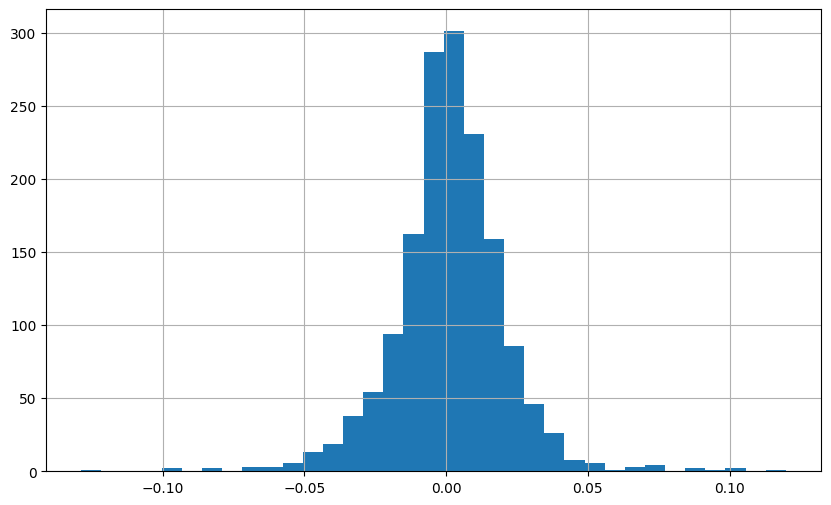

In [7]:
datos['rendim_diario'].hist(bins=35, figsize=(10, 6))

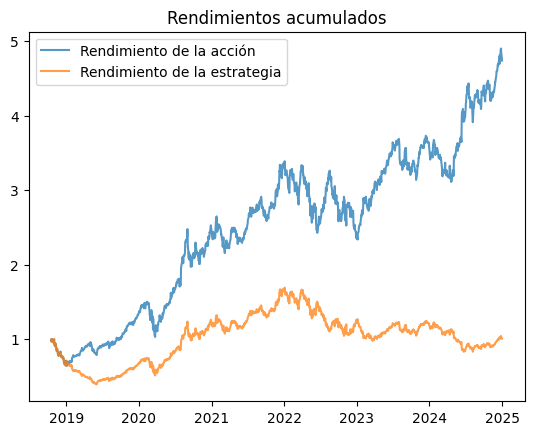

In [8]:
plt.plot(datos['rendim_acumulado_accion'], label = 'Rendimiento de la acción', alpha = 0.75)
plt.plot(datos['rendim_acumlado_estrategia'], label = 'Rendimiento de la estrategia', alpha = 0.75)
plt.title("Rendimientos acumulados")
plt.legend()
plt.show()

In [9]:
# Rendimiento anual medio
datos[['rendim_diario', 'rendim_estrategia']].mean() * 252

,,0
Price,Ticker,
rendim_diario,,0.300190
rendim_estrategia,,0.050677


In [10]:
# Tasa de rendimiento anual
np.exp(datos[['rendim_diario', 'rendim_estrategia']].mean() * 252) - 1

,,0
Price,Ticker,
rendim_diario,,0.350116
rendim_estrategia,,0.051983


In [11]:
# Desviación estándar anual
datos[['rendim_diario', 'rendim_estrategia']].std() * 252 ** 0.5

,,0
Price,Ticker,
rendim_diario,,0.312922
rendim_estrategia,,0.313477


In [12]:
datos['max_acumulado'] = datos['rendim_acumlado_estrategia'].cummax()

In [13]:
datos.tail()

Price,Close,High,Low,Open,Volume,SMA_corto,SMA_largo,signal,posicion,rendim_diario,rendim_estrategia,rendim_acumulado_accion,rendim_acumlado_estrategia,max_acumulado
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,
Date,,,,,,,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,234.988821,210.666910,1,1.0,0.011478,0.011478,4.884493,1.040231,1.692296
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,235.495562,211.097454,1,1.0,0.003176,0.003176,4.900004,1.043535,1.692296
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,235.975154,211.521334,1,1.0,-0.013242,-0.013242,4.835117,1.029716,1.692296
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,236.379820,211.919041,1,1.0,-0.013263,-0.013263,4.770987,1.016059,1.692296
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,236.692276,212.309766,1,1.0,-0.007058,-0.007058,4.737314,1.008887,1.692296


<Axes: xlabel='Date'>

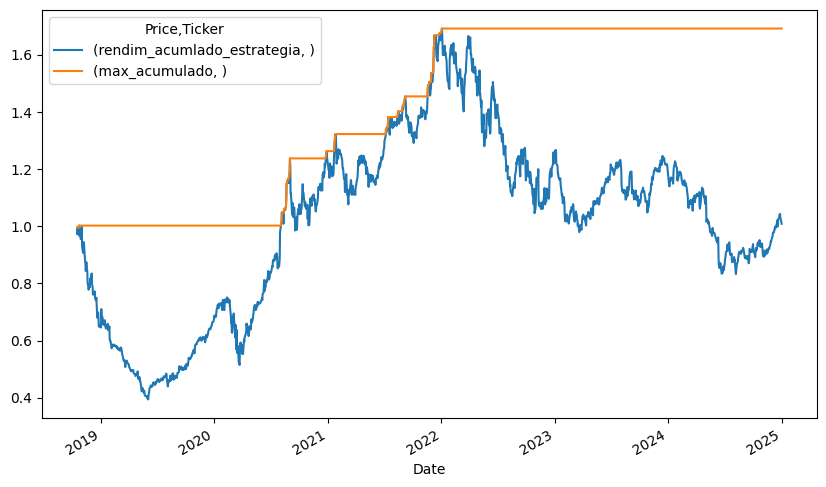

In [14]:
datos[['rendim_acumlado_estrategia', 'max_acumulado']].dropna().plot(figsize=(10, 6))

# Estrategia MACD

+ MACD significa Moving Average Convergence Divergence o Convergencia/Divergencia de Medias Móviles.

+ Es un indicador técnico utilizado en trading para identificar:

    + Cambios en la tendencia
    + Momentum (fuerza) del precio
    + Posibles puntos de entrada o salida

+ Fue propuesto por Gerald Appel
+ Se usa en mercados de acciones, forex y criptomonedas.

El indicador MACD tiene tres componentes importantes:

1. Línea MACD:

+ Esta componente representa la diferencia entre dos Medias Móviles Exponenciales (EMAs). Para calcular la línea MACD, se obtiene primero una EMA con un período más largo y otra EMA con un período más corto

+ Generalmente, los valores más utilizados para estas longitudes son 12 (rápida) y 26 (lenta).

+ Los valores finales de la línea MACD se obtienen restando la EMA lenta de la EMA rápida.

+ La fórmula para calcular la línea MACD se expresa como:

$$\text{MACD} = \text{EMA}_{rapido} - \text{EMA}_{lenta}$$

2. Línea de Señal:

+ Esta línea es la Media Móvil Exponencial de la propia línea MACD, calculada sobre un período específico, comúnmente de 9 sesiones.

+ Como la línea de señal suaviza los valores de la línea MACD, ofrece una representación "más clara" de la tendencia.

3. Histograma:
Es un histograma que representa visualmente la diferencia entre la línea MACD y la línea de Señal.
Sirve como una herramienta útil para identificar cambios de tendencia y fuerza del movimiento.

In [15]:
# Se obtienen los datos históricos de Yahoo Finance
datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)

short_window = 14
long_window = 26
datos['ema_corto'] = datos['Close'].ewm(span = short_window, adjust=False).mean()
datos['ema_largo'] = datos['Close'].ewm(span = long_window, adjust=False).mean()
macd = datos['ema_corto'] - datos['ema_largo']
signals = macd.ewm(span=9, adjust=False).mean()
datos["MACD"] = macd
datos["MACD_signal"] = signals

/tmp/ipython-input-1100873576.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
[*********************100%***********************]  1 of 1 completed


In [16]:
signal = np.where((datos["MACD"] > datos["MACD_signal"]) & (datos["MACD"].shift(1) <= datos["MACD_signal"].shift(1)), 1, -1)
datos["signal"] = np.where(datos["MACD"].isnull(), 0, signal)

In [17]:
# Se genera una columna de posiciones, se recorren las señales para evitar
# El sesgo look-akead
# La posición refleja la señal del día anterior
datos['posicion'] = datos['signal'].shift(1)

# Se calcula el cambio porcentual diario del precio de la acción
datos['rendim_diario'] = datos['Close'].pct_change()

datos['rendim_estrategia'] = datos['posicion'] * datos['rendim_diario']

# Se obtienen los rendimientos acumulados
datos['rendim_acumulado_accion'] = (1 + datos['rendim_diario']).cumprod()
datos['rendim_acumlado_estrategia'] = (1 + datos['rendim_estrategia']).cumprod()

In [18]:
datos.tail()

Price,Close,High,Low,Open,Volume,ema_corto,ema_largo,MACD,MACD_signal,signal,posicion,rendim_diario,rendim_estrategia,rendim_acumulado_accion,rendim_acumlado_estrategia
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,248.552607,243.521188,5.031419,4.433707,-1,-1.0,0.011478,-0.011478,6.371479,0.128376
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,249.826090,244.601377,5.224714,4.591908,-1,-1.0,0.003176,-0.003176,6.391713,0.127969
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,250.474061,245.348376,5.125685,4.698663,-1,-1.0,-0.013242,0.013242,6.307072,0.129663
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,250.585236,245.789820,4.795416,4.718014,-1,-1.0,-0.013263,0.013263,6.223419,0.131383
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,250.445095,246.067180,4.377915,4.649994,-1,-1.0,-0.007058,0.007058,6.179495,0.132310


+ La visualización de las SMAs ayuda a identificar zonas de compra/venta cuando la SMA50 cruza por encima o por debajo de la SMA200.

+ Los gráfico de rendimientos acumulados compara el performance de la estrategia frente a mantener la acción sin aplicar ninguna estrategia de trading activa

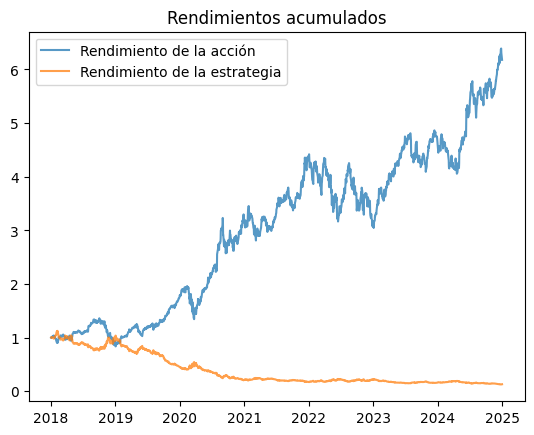

In [19]:
plt.plot(datos['rendim_acumulado_accion'], label = 'Rendimiento de la acción', alpha = 0.75)
plt.plot(datos['rendim_acumlado_estrategia'], label = 'Rendimiento de la estrategia', alpha = 0.75)
plt.title("Rendimientos acumulados")
plt.legend()
plt.show()

In [20]:
# Rendimiento anual medio
datos[['rendim_diario', 'rendim_estrategia']].mean() * 252

,,0
Price,Ticker,
rendim_diario,,0.307545
rendim_estrategia,,-0.242610


In [21]:
# Tasa de rendimiento anual
np.exp(datos[['rendim_diario', 'rendim_estrategia']].mean() * 252) - 1

,,0
Price,Ticker,
rendim_diario,,0.360081
rendim_estrategia,,-0.215423


In [22]:
# Desviación estándar anual
datos[['rendim_diario', 'rendim_estrategia']].std() * 252 ** 0.5

,,0
Price,Ticker,
rendim_diario,,0.305464
rendim_estrategia,,0.305696


In [23]:
datos['max_acumulado'] = datos['rendim_acumlado_estrategia'].cummax()

<Axes: xlabel='Date'>

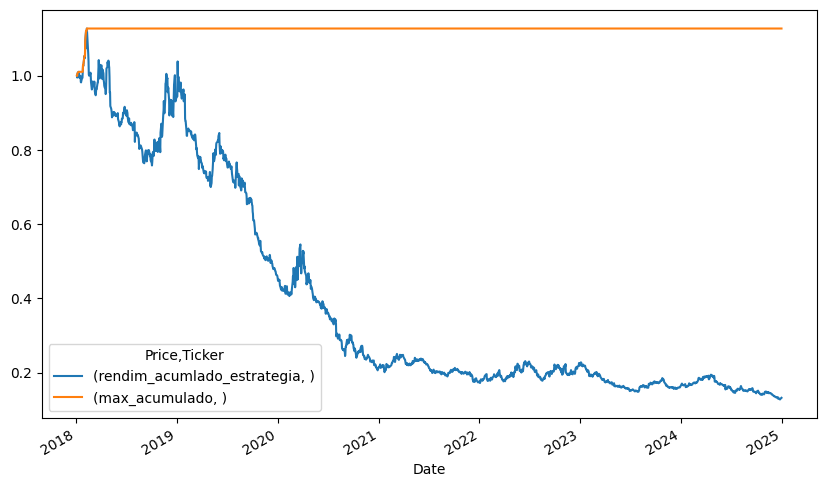

In [24]:
datos[['rendim_acumlado_estrategia', 'max_acumulado']].dropna().plot(figsize=(10, 6))

# SMA con EMA

Acá se usa una Exponentially Weighted Moving Average (EWMA / EWM)

$$EWM_t = \alpha P_t + (1 - \alpha)\,EWM_{t-1}$$

donde

* $EWM_t$: Exponentially weighted moving average al tiempo $t$
* $P_t$ = Precio al tiempo $t$
* $\alpha \in (0,1)$ : Factor de suavizamiento. $\alpha$ grande dará más ponderación a las observaciones recientes

In [25]:
# Se obtienen los datos históricos de Yahoo Finance
datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
# Dropping a level down
datos.columns = datos.columns.droplevel(1)

/tmp/ipython-input-2548761099.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
[*********************100%***********************]  1 of 1 completed


In [26]:
long_window = 200

datos['SMA'] = datos['Close'].rolling(window = long_window).mean()
datos['EMA'] = datos['Close'].ewm(span = long_window, adjust=False).mean()


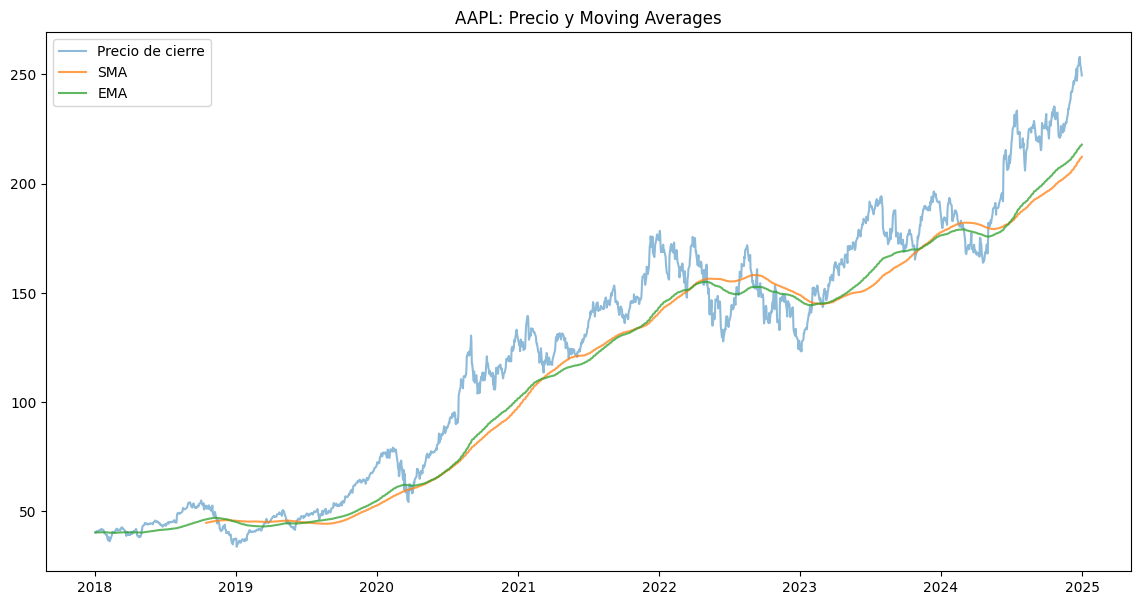

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(datos['Close'], label='Precio de cierre', alpha=0.5)
plt.plot(datos['SMA'], label='SMA', alpha=0.75)
plt.plot(datos['EMA'], label='EMA', alpha=0.75)
plt.title(f"{ticker}: Precio y Moving Averages")
plt.legend()
plt.show()

In [28]:
# Construimos la regla
signal = np.where((datos["Close"] > datos["SMA"]) & (datos["Close"] > datos["EMA"]), 1, -1)
datos["signal"] = np.where(datos["Close"].isnull(), 0, signal)

# Se eliminan los NAs
datos = datos.dropna().copy()

In [29]:
datos.tail()

Price,Close,High,Low,Open,Volume,SMA,EMA,signal
Date,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,210.666910,216.444863,1
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,211.097454,216.859379,1
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,211.521334,217.235762,1
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,211.919041,217.574788,1
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,212.309766,217.892792,1


In [30]:
# Se genera una columna de posiciones, se recorren las señales para evitar
# El sesgo look-akead
# La posición refleja la señal del día anterior
datos['posicion'] = datos['signal'].shift(1)

# Se calcula el cambio porcentual diario del precio de la acción
datos['rendim_diario'] = datos['Close'].pct_change()

datos['rendim_estrategia'] = datos['posicion'] * datos['rendim_diario']

# Se obtienen los rendimientos acumulados
datos['rendim_acumulado_accion'] = (1 + datos['rendim_diario']).cumprod()
datos['rendim_acumlado_estrategia'] = (1 + datos['rendim_estrategia']).cumprod()

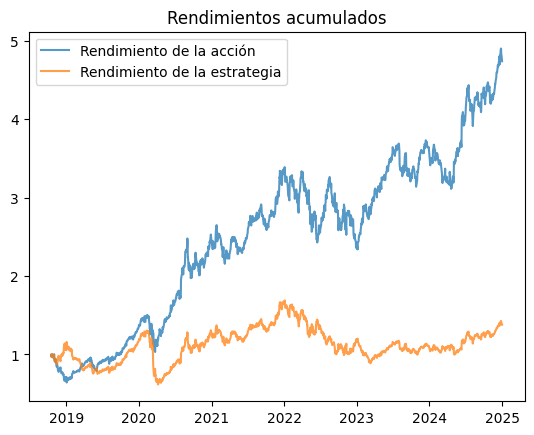

In [31]:
plt.plot(datos['rendim_acumulado_accion'], label = 'Rendimiento de la acción', alpha = 0.75)
plt.plot(datos['rendim_acumlado_estrategia'], label = 'Rendimiento de la estrategia', alpha = 0.75)
plt.title("Rendimientos acumulados")
plt.legend()
plt.show()

In [32]:
# Rendimiento anual medio
datos[['rendim_diario', 'rendim_estrategia']].mean() * 252

,0
Price,
rendim_diario,0.300190
rendim_estrategia,0.101412


In [33]:
# Tasa de rendimiento anual
np.exp(datos[['rendim_diario', 'rendim_estrategia']].mean() * 252) - 1

,0
Price,
rendim_diario,0.350116
rendim_estrategia,0.106733


In [34]:
# Desviación estándar anual
datos[['rendim_diario', 'rendim_estrategia']].std() * 252 ** 0.5

,0
Price,
rendim_diario,0.312922
rendim_estrategia,0.313428


In [35]:
datos['max_acumulado'] = datos['rendim_acumlado_estrategia'].cummax()

<Axes: xlabel='Date'>

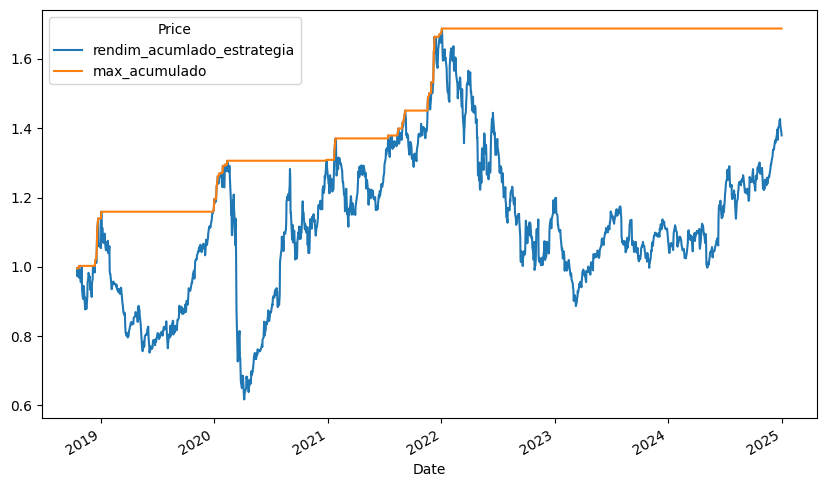

In [36]:
datos[['rendim_acumlado_estrategia', 'max_acumulado']].dropna().plot(figsize=(10, 6))

# Bandas de Bollinger

Cálculo:

+ Media = SMA(precio, 20)
+ Desviación = STD(precio, 20)
+ Banda_superior = Media + (2 × Desviación)
+ Banda_inferior = Media - (2 × Desviación)

Señales:

+ COMPRA: precio(t) ≤ Banda_inferior Y precio(t) > precio(t-1)
+ VENTA: precio(t) ≥ Banda_superior Y precio(t) < precio(t-1)

In [37]:
# Se obtienen los datos históricos de Yahoo Finance
datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
# Dropping a level down
datos.columns = datos.columns.droplevel(1)

/tmp/ipython-input-2548761099.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
[*********************100%***********************]  1 of 1 completed


In [38]:
long_window = 20

datos['media_movil'] = datos['Close'].rolling(window = long_window).mean()
datos['desviacion_movil'] = datos['Close'].rolling(window = long_window).std()

datos['banda_superior'] = datos['media_movil'] + (2 * datos['desviacion_movil'])
datos['banda_inferior'] = datos['media_movil'] - (2 * datos['desviacion_movil'])

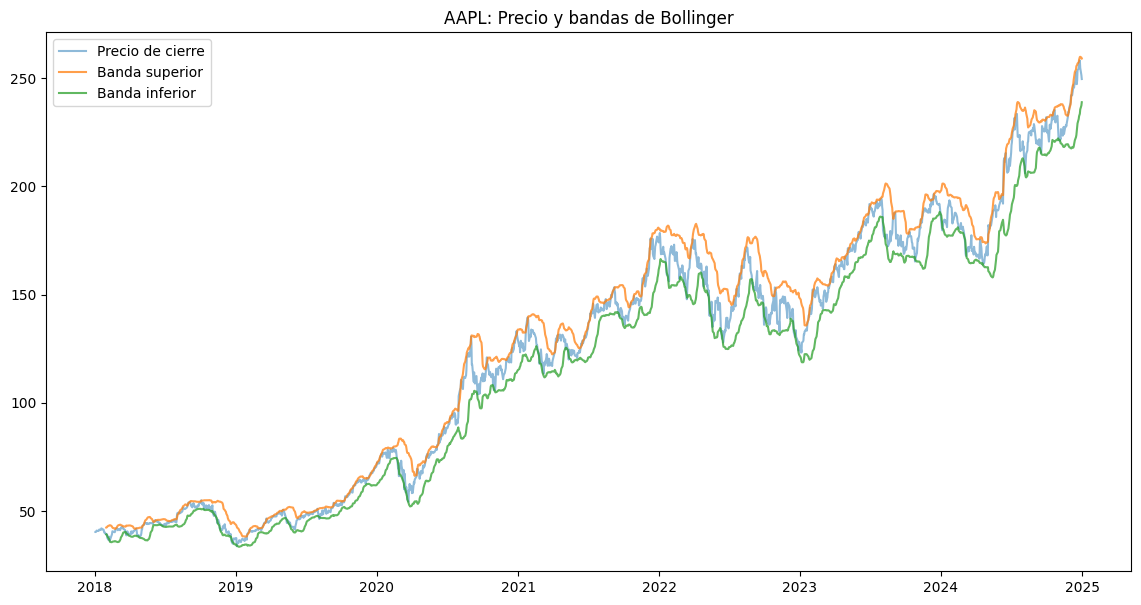

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(datos['Close'], label='Precio de cierre', alpha=0.5)
plt.plot(datos['banda_superior'], label = 'Banda superior', alpha=0.75)
plt.plot(datos['banda_inferior'], label = 'Banda inferior', alpha=0.75)
plt.title(f"{ticker}: Precio y bandas de Bollinger")
plt.legend()
plt.show()

In [40]:
signal = np.where((datos["Close"] <= datos["banda_inferior"]), 1, -1)
#signal = np.where((datos["Close"] <= datos["banda_inferior"]) & (datos["Close"] > datos["Close"].shift(1)), 1, -1)
datos["signal"] = np.where(datos["Close"].isnull(), 0, signal)

# Se eliminan los NAs
datos = datos.dropna().copy()

In [41]:
datos.tail()

Price,Close,High,Low,Open,Volume,media_movil,desviacion_movil,banda_superior,banda_inferior,signal
Date,,,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,245.422270,6.525270,258.472811,232.371729,-1
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,246.616031,6.553512,259.723055,233.509007,-1
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,247.645377,6.083956,259.813288,235.477465,-1
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,248.386246,5.531159,259.448563,237.323928,-1
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,248.925831,5.045963,259.017756,238.833905,-1


In [42]:
# Se genera una columna de posiciones, se recorren las señales para evitar
# El sesgo look-akead
# La posición refleja la señal del día anterior
datos['posicion'] = datos['signal'].shift(1)

# Se calcula el cambio porcentual diario del precio de la acción
datos['rendim_diario'] = datos['Close'].pct_change()

datos['rendim_estrategia'] = datos['posicion'] * datos['rendim_diario']

# Se obtienen los rendimientos acumulados
datos['rendim_acumulado_accion'] = (1 + datos['rendim_diario']).cumprod()
datos['rendim_acumlado_estrategia'] = (1 + datos['rendim_estrategia']).cumprod()

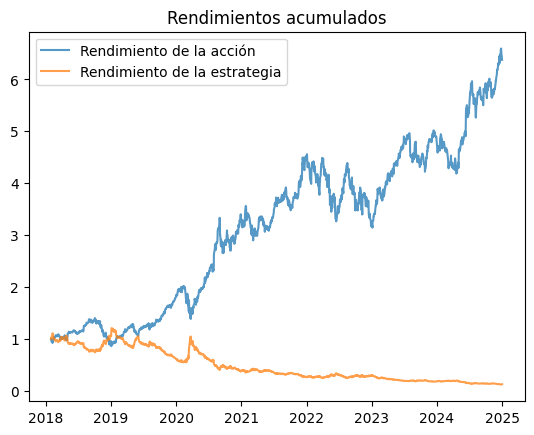

In [43]:
plt.plot(datos['rendim_acumulado_accion'], label = 'Rendimiento de la acción', alpha = 0.75)
plt.plot(datos['rendim_acumlado_estrategia'], label = 'Rendimiento de la estrategia', alpha = 0.75)
plt.title("Rendimientos acumulados")
plt.legend()
plt.show()

In [44]:
# Rendimiento anual medio
datos[['rendim_diario', 'rendim_estrategia']].mean() * 252

,0
Price,
rendim_diario,0.315290
rendim_estrategia,-0.247092


In [45]:
# Tasa de rendimiento anual
np.exp(datos[['rendim_diario', 'rendim_estrategia']].mean() * 252) - 1

,0
Price,
rendim_diario,0.370656
rendim_estrategia,-0.218931


In [46]:
# Desviación estándar anual
datos[['rendim_diario', 'rendim_estrategia']].std() * 252 ** 0.5

,0
Price,
rendim_diario,0.306694
rendim_estrategia,0.306942


In [47]:
datos['max_acumulado'] = datos['rendim_acumlado_estrategia'].cummax()

<Axes: xlabel='Date'>

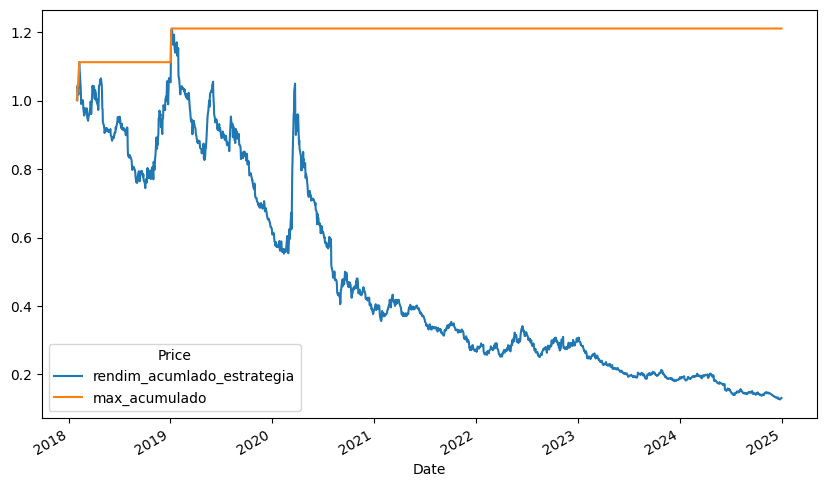

In [48]:
datos[['rendim_acumlado_estrategia', 'max_acumulado']].dropna().plot(figsize=(10, 6))

## RSI (Índice de Fuerza Relativa)

+ El **RSI (Relative Strength Index)** es un indicador que mide la "fuerza del movimiento del precio".

+ Sirve para identificar si un activo está:

  * Sobrecomprado: El precio puede estar "demasiado alto" y podría corregir.
  * Sobrevendido: El precio puede estar "demasiado bajo" y podría rebotar.

+ El RSI te dice si el precio está subiendo o bajando con mucha o poca fuerza, ayudando a detectar excesos y posibles cambios "súbitos".

+ Fue propuesto por J. Welles Wilder.

Mide la relación entre:

* La magnitud de las "subidas recientes" del precio
  vs. la magnitud de las "bajadas recientes" y lo expresa como un número entre 0 y 100.

+ Generalmente se calcula usando 14 períodos.

**Cálculo:**
- RS = Promedio de ganancias (n períodos) / Promedio de pérdidas (n períodos)
- RSI = 100 - (100 / (1 + RS))
- Donde n = 14 períodos típicamente

La regla empírica dice que:

+ $<30$: Sobrevendido, i.e. podría venir una subida o rebote
+ $\approx$ 50: Zona neutral, i.e. no hay fuerza clara
+ $>70$: Sobrecomprado, i.e. podría venir una baja o corrección

**Señales:**

- **COMPRA**: RSI < 30
- **VENTA**: RSI > 70

**Observaciones:**

+ Obviamente **no es automático**, son **posibles escenarios**, no garantías.
+ Si la **tendencia es alcista**, muchxs traders sólo toman señales de compra (rebotes desde RSI 30–40).
+ Si la **tendencia es bajista**, toman señales de venta (rechazos desde RSI 60–70).
+ La idea es evitar muchas señales falsas.
+ Suele combinarse con MACD o soportes/resistencias

In [49]:
# Se obtienen los datos históricos de Yahoo Finance
datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
# Dropping a level down
datos.columns = datos.columns.droplevel(1)

/tmp/ipython-input-2548761099.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, start = fecha_inicio, end = fecha_final)
[*********************100%***********************]  1 of 1 completed


In [50]:
# Se define el periodo para el RSI
n_rsi = 14

# Calculate price changes
datos['cambio'] = datos['Close'].diff()

# Se calcular las pérdidas y ganancias
datos['gain'] = datos['cambio'].apply(lambda x: x if x > 0 else 0)
datos['loss'] = datos['cambio'].apply(lambda x: abs(x) if x < 0 else 0)

datos['avg_gain'] = datos['gain'].ewm(span = n_rsi, adjust=False).mean()
datos['avg_loss'] = datos['loss'].ewm(span = n_rsi, adjust=False).mean()

# Se calcula la Relative Strength (RS)
datos['rs'] = datos['avg_gain'] / datos['avg_loss']

# Finalmente se calculate el RSI
datos['rsi'] = 100 - (100 / (1 + datos['rs']))

In [51]:
signal = np.where((datos['rsi'] < 30), 1, 0)
signal = np.where((datos['rsi'] >70), -1, signal)
datos["signal"] = np.where(datos["Close"].isnull(), 0, signal)

# Se eliminan los NAs
datos = datos.dropna().copy()

In [52]:
datos.tail()

Price,Close,High,Low,Open,Volume,cambio,gain,loss,avg_gain,avg_loss,rs,rsi,signal
Date,,,,,,,,,,,,,
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,2.919678,2.919678,0.000000,1.833723,0.490019,3.742146,78.912502,-1
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,0.817047,0.817047,0.000000,1.698166,0.424683,3.998666,79.994663,-1
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,-3.417862,0.000000,3.417862,1.471744,0.823774,1.786588,64.113816,0
2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500,-3.377991,0.000000,3.377991,1.275511,1.164336,1.095484,52.278328,0
2024-12-31,249.534180,252.384064,248.547676,251.547039,39480700,-1.773697,0.000000,1.773697,1.105443,1.245584,0.887490,47.019582,0


In [53]:
# Se genera una columna de posiciones, se recorren las señales para evitar
# El sesgo look-akead
# La posición refleja la señal del día anterior
datos['posicion'] = datos['signal'].shift(1)

# Se calcula el cambio porcentual diario del precio de la acción
datos['rendim_diario'] = datos['Close'].pct_change()

datos['rendim_estrategia'] = datos['posicion'] * datos['rendim_diario']

# Se obtienen los rendimientos acumulados
datos['rendim_acumulado_accion'] = (1 + datos['rendim_diario']).cumprod()
datos['rendim_acumlado_estrategia'] = (1 + datos['rendim_estrategia']).cumprod()

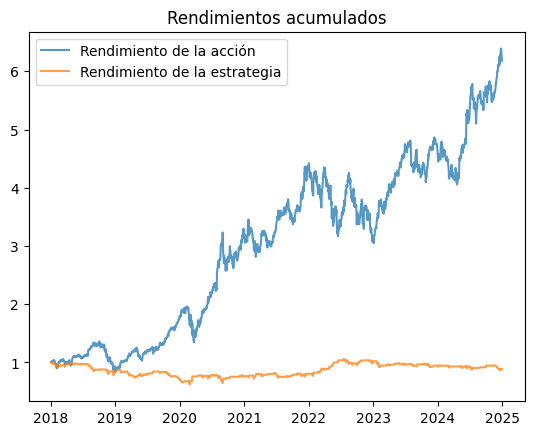

In [54]:
plt.plot(datos['rendim_acumulado_accion'], label = 'Rendimiento de la acción', alpha = 0.75)
plt.plot(datos['rendim_acumlado_estrategia'], label = 'Rendimiento de la estrategia', alpha = 0.75)
plt.title("Rendimientos acumulados")
plt.legend()
plt.show()

In [55]:
# Rendimiento anual medio
datos[['rendim_diario', 'rendim_estrategia']].mean() * 252

,0
Price,
rendim_diario,0.307744
rendim_estrategia,-0.005466


In [56]:
# Tasa de rendimiento anual
np.exp(datos[['rendim_diario', 'rendim_estrategia']].mean() * 252) - 1

,0
Price,
rendim_diario,0.360353
rendim_estrategia,-0.005451


In [57]:
# Desviación estándar anual
datos[['rendim_diario', 'rendim_estrategia']].std() * 252 ** 0.5

,0
Price,
rendim_diario,0.305550
rendim_estrategia,0.157834


In [58]:
datos['max_acumulado'] = datos['rendim_acumlado_estrategia'].cummax()

<Axes: xlabel='Date'>

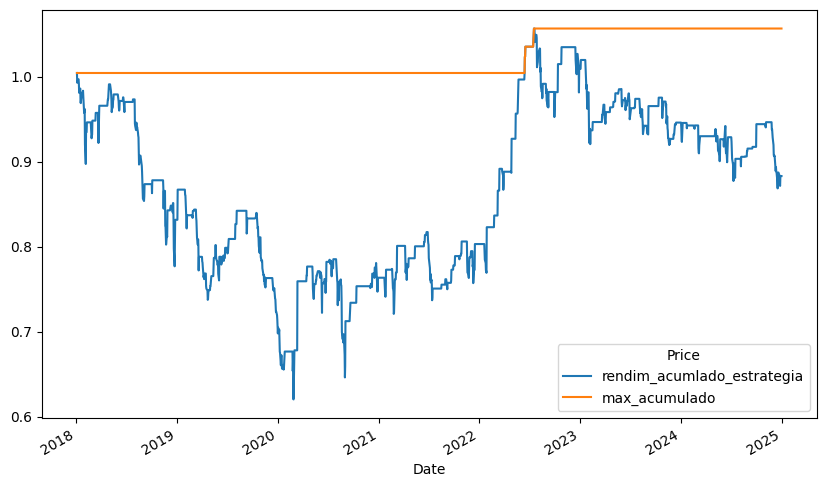

In [59]:
datos[['rendim_acumlado_estrategia', 'max_acumulado']].dropna().plot(figsize=(10, 6))